# Assessed Coursework

## Setup & Preparation

In [1]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/maciejkula/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  3628k      0  0:00:02  0:00:02 --:--:-- 3626k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0  1828k      0  0:00:01  0:00:01 --:--:-- 1828k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  4436k      0  0:00:01  0:00:01 --:--:-- 4436k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0  1471k      0  0:00:01  0:00:01 --:--:-- 1471k
  Cloning https://github.com/maciejkula/spotlight.gi

In [0]:
from collections import defaultdict
from itertools import count
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [26]:
#construct interactions from to_read_df
uid_map1 = defaultdict(count().__next__)
iid_map1 = defaultdict(count().__next__)
uids1 = np.array([uid_map1[uid] for uid in to_read_df["user_id"].values ], dtype=np.int32)
iids1 = np.array([iid_map1[iid] for iid in to_read_df["book_id"].values ], dtype=np.int32)
uid_rev_map1 = {v: k for k, v in uid_map1.items()}
iid_rev_map1 = {v: k for k, v in iid_map1.items()}
imp_dataset = Interactions(user_ids=uids1,
                                  item_ids=iids1, 
                                  num_users  = len(uid_map1),
                                  num_items = 7293 #len(iid_rev_map1)
                          )
imp_train, imp_validation = random_train_test_split(imp_dataset, test_percentage=0.2, random_state=np.random.seed(42)) 
print(imp_train)
print(imp_validation)

<Interactions dataset (5000 users x 7293 items x 391536 interactions)>
<Interactions dataset (5000 users x 7293 items x 97884 interactions)>


In [27]:
#construct interactions from test.csv
uid_map2 = defaultdict(count().__next__)
iid_map2 = defaultdict(count().__next__)
uids2 = np.array([uid_map2[uid] for uid in test["user_id"].values ], dtype=np.int32)
iids2 = np.array([iid_map2[iid] for iid in test["book_id"].values ], dtype=np.int32)
uid_rev_map2 = {v: k for k, v in uid_map2.items()}
iid_rev_map2 = {v: k for k, v in iid_map2.items()}
test_dataset = Interactions(user_ids=uids2,
                                  item_ids=iids2,
                                  num_users  = len(uid_map1),
                                  num_items = 7293 #len(iid_rev_map3)
                           )
print(test_dataset)

<Interactions dataset (5000 users x 7293 items x 122356 interactions)>


In [28]:
#construct interactions from ratings_df
uid_map3 = defaultdict(count().__next__)
iid_map3 = defaultdict(count().__next__)
uids3 = np.array([uid_map3[uid] for uid in ratings_df["user_id"].values ], dtype=np.int32)
iids3 = np.array([iid_map3[iid] for iid in ratings_df["book_id"].values ], dtype=np.int32)
uid_rev_map3 = {v: k for k, v in uid_map3.items()}
iid_rev_map3 = {v: k for k, v in iid_map3.items()}
ratings = ratings_df["rating"].values.astype(np.float32)
exp_dataset = Interactions(user_ids=uids3,
                                  item_ids=iids3,
                                  ratings=ratings,
                                  num_users  = len(uid_map3),
                                  num_items = 7293 #len(iid_rev_map3)
                          )
exp_train, exp_validation = random_train_test_split(exp_dataset, test_percentage=0.2, random_state=np.random.seed(42)) 
print(exp_train)
print(exp_validation)

<Interactions dataset (5000 users x 7293 items x 351874 interactions)>
<Interactions dataset (5000 users x 7293 items x 87969 interactions)>


In [0]:
#generate array of predicted results
def scoreAll(model):
  scoresForAllUsers=[]
  for uid in range(0,model._num_users):
    scoresForAllUsers.append(model.predict(uid))
  return scoresForAllUsers

In [0]:
#calculate Reciprocal Rank
import scipy.stats as st
def calc_reciprank(testInteractions, predictions_for_each_user, train=None, cutoff=0):
  FLOAT_MAX = np.finfo(np.float32).max
  assert testInteractions.num_users == len(predictions_for_each_user), "mismatch: num users in Interactions %d, num users in predictions was %d" % (testInteractions.num_users,len(predictions_for_each_user))
  assert testInteractions.num_items == len(predictions_for_each_user[0]), "mismatch: num items in Interactions %d, num items in predictions was %d" % (testInteractions.num_items, len(predictions_for_each_user[0]))
  
  rrs = []
  
  if train is not None:
    train = train.tocsr()
    
    i=-1
  for user_id, row in enumerate(testInteractions.tocsr()):
    i=i+1
    if not len(row.indices):
      rrs.append(0)
      continue
      
    predictions = -predictions_for_each_user[i]
    
    #if train is set, remove the interactions from the training dataset
    if train is not None:
      predictions[train[user_id].indices] = FLOAT_MAX
    
    rank = st.rankdata(predictions)[row.indices].min()
    
    if cutoff > 0 and rank > cutoff:
      rrs.append(0)
      continue
    
    rrs.append(1.0 / rank)
  return np.array(rrs)

## Question 1

In [0]:
#Average rating
book_groups = ratings_df.groupby('book_id')
avg_rating = []
for i in range(0, len(uid_map1)):
  avg_rating.append(book_groups['rating'].mean().as_matrix())
MRR_avg = calc_reciprank(test_dataset, avg_rating, train=exp_dataset).mean()
print("MRR of average rating: ", MRR_avg)

MRR of average rating:  0.006494006221642157


In [0]:
#Number of ratings
book_groups = books_df.groupby('book_id')
num_rating = []
for i in range(0, len(uid_map1)):
  num_rating.append(book_groups['ratings_count'].mean().as_matrix())
MRR_num_rating = calc_reciprank(test_dataset, num_rating, train=exp_dataset).mean()
print("MRR of number of ratings: ", MRR_num_rating)

MRR of number of ratings:  0.014013194011115017


In [0]:
#Number of 5* ratings
num_rating_5 = []
for i in range(0, len(uid_map1)):
  num_rating_5.append(book_groups['ratings_5'].mean().as_matrix())
MRR_num_rating_5 = calc_reciprank(test_dataset, num_rating_5, train=exp_dataset).mean()
print("MRR of number of 5* ratings: ", MRR_num_rating_5)

MRR of number of 5* ratings:  0.01399831337337485


In [19]:
#Fraction of 5* ratings
book_groups = books_df.groupby('book_id')
fra_rating_5 = []
for i in range(0, len(uid_map1)):
  fra_rating_5.append((book_groups['ratings_5'].mean()/book_groups['ratings_count'].mean()).as_matrix())
RR_fra_rating_5 = calc_reciprank(test_dataset, fra_rating_5, train=exp_dataset)
MRR_fra_rating_5 = RR_fra_rating_5.mean()
print("MRR of fraction of 5* ratings: ", MRR_fra_rating_5)

MRR of fraction of 5* ratings:  0.01987883322136634


####  So, the best model of Question 1 is Fraction of 5* ratings(fra_rating_5)




## Question 2

In [0]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel

In [29]:
#ExplicitFactorizationModel
emodel = ExplicitFactorizationModel(n_iter=10,
                                    embedding_dim=32, 
                                    use_cuda=False)
emodel.fit(exp_train, verbose=True)
score_emodel = scoreAll(emodel)
print(calc_reciprank(exp_validation, score_emodel, train=exp_train).mean())


#ImplicitFactorizationModel
imodel = ImplicitFactorizationModel(n_iter=10,
                                    loss='bpr',
                                    embedding_dim=32, 
                                    use_cuda=False)
imodel.fit(exp_train, verbose=True)
score_imodel_32_on_exp = scoreAll(imodel)
print(calc_reciprank(exp_validation, score_imodel_32_on_exp, train=exp_train).mean())

Epoch 0: loss 3.0165111474557356
Epoch 1: loss 0.8646718727458607
Epoch 2: loss 0.7403059392408892
Epoch 3: loss 0.6818284102136438
Epoch 4: loss 0.6431102196520025
Epoch 5: loss 0.6159999634352598
Epoch 6: loss 0.5924424318400296
Epoch 7: loss 0.5753619143529372
Epoch 8: loss 0.5590689725875855
Epoch 9: loss 0.54736697194793
0.016408424716078382


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0: loss 0.24524462684176185
Epoch 1: loss 0.12919488742134788
Epoch 2: loss 0.10339227915622971
Epoch 3: loss 0.09114607984640381
Epoch 4: loss 0.08434333243153312
Epoch 5: loss 0.07986670026047664
Epoch 6: loss 0.07623079366575587
Epoch 7: loss 0.07326604598218744
Epoch 8: loss 0.07155607979812405
Epoch 9: loss 0.06966055599125949
0.2774339822590833


In [0]:
#ImplicitFactorizationModel is more effective
#tune the number of latent factors
imodel_64 = ImplicitFactorizationModel(n_iter=10,
                                       loss='bpr',
                                    embedding_dim=64, 
                                    use_cuda=False)
imodel_64.fit(exp_train, verbose=True)
print(calc_reciprank(exp_validation, scoreAll(imodel_64), train=exp_train).mean())

imodel_128 = ImplicitFactorizationModel(n_iter=10,
                                        loss='bpr',
                                    embedding_dim=128, 
                                    use_cuda=False)
imodel_128.fit(exp_train, verbose=True)
print(calc_reciprank(exp_validation, scoreAll(imodel_128), train=exp_train).mean())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0: loss 0.23533462724360552
Epoch 1: loss 0.12042723202705383
Epoch 2: loss 0.0950146360532804
Epoch 3: loss 0.08359565230933103
Epoch 4: loss 0.07657190827077086
Epoch 5: loss 0.07205486133559183
Epoch 6: loss 0.06949330801855434
Epoch 7: loss 0.06692750533331525
Epoch 8: loss 0.06427266551689668
Epoch 9: loss 0.06222000433369116
0.2672900773522812
Epoch 0: loss 0.22984673409028486
Epoch 1: loss 0.11018082508715717
Epoch 2: loss 0.08863035215301947
Epoch 3: loss 0.0792751209221103
Epoch 4: loss 0.07267859537493099
Epoch 5: loss 0.06920123503966764
Epoch 6: loss 0.06523073932799427
Epoch 7: loss 0.06342590840567242
Epoch 8: loss 0.060936126122420484
Epoch 9: loss 0.058823047050020914
0.27100480902817553


In [0]:
#the best model is imodel, in which latent factor is 32 
RR_Q2 = calc_reciprank(test_dataset, scoreAll(imodel), train=exp_dataset)
MRR_Q2 = RR_Q2.mean()
print("MRR of ImplicitFactorizationModel with latent factor 32 is : ",MRR_Q2)

MRR of ImplicitFactorizationModel with latent factor 32 is :  0.04371197961672561


## Question 3

In [30]:
#deploy ImplicitFactorizationModel on implicit data
from spotlight.factorization.implicit import ImplicitFactorizationModel
imodel_imp = ImplicitFactorizationModel(n_iter=10,
                                    loss='bpr',
                                    embedding_dim=32, 
                                    use_cuda=False)
imodel_imp.fit(imp_train, verbose=True)
print(calc_reciprank(imp_validation, scoreAll(imodel_imp), train=imp_train).mean())

imodel_imp_64 = ImplicitFactorizationModel(n_iter=10,
                                    loss='bpr',
                                    embedding_dim=64, 
                                    use_cuda=False)
imodel_imp_64.fit(imp_train, verbose=True)
print(calc_reciprank(imp_validation, scoreAll(imodel_imp_64), train=imp_train).mean())

imodel_imp_128 = ImplicitFactorizationModel(n_iter=10,
                                    loss='bpr',
                                    embedding_dim=128, 
                                    use_cuda=False)
imodel_imp_128.fit(imp_train, verbose=True)
score_imodel_128_on_imp = scoreAll(imodel_imp_128)
print(calc_reciprank(imp_validation, scoreAll(imodel_imp_128), train=imp_train).mean())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0: loss 0.2467148983351935
Epoch 1: loss 0.134309152333565
Epoch 2: loss 0.10849952090750722
Epoch 3: loss 0.09759753012384464
Epoch 4: loss 0.09085121446721305
Epoch 5: loss 0.08597655207454379
Epoch 6: loss 0.08308086735896425
Epoch 7: loss 0.0801329053792299
Epoch 8: loss 0.0781126961245938
Epoch 9: loss 0.07528190242942252
0.2875669649012103
Epoch 0: loss 0.2358908500838903
Epoch 1: loss 0.12518706766316315
Epoch 2: loss 0.10211816473188354
Epoch 3: loss 0.0909201378574948
Epoch 4: loss 0.08396472975830821
Epoch 5: loss 0.07951270252880123
Epoch 6: loss 0.07640337039734803
Epoch 7: loss 0.07326004261917927
Epoch 8: loss 0.07154952817979982
Epoch 9: loss 0.0689397571681469
0.26981536649677174
Epoch 0: loss 0.23069600087462688
Epoch 1: loss 0.11748053740734368
Epoch 2: loss 0.09653042076898166
Epoch 3: loss 0.08567485770368888
Epoch 4: loss 0.0800665387530732
Epoch 5: loss 0.07613243237137794
Epoch 6: loss 0.07259592729699768
Epoch 7: loss 0.07005914781924362
Epoch 8: loss 0.06

In [0]:
#the best model is imodel_imp,  in which the latent factor is 32
predicted_scores_for_all = scoreAll(imodel_imp)
RR_32 = calc_reciprank(test_dataset, predicted_scores_for_all, train=imp_train)
MRR_32 = RR_32.mean()
print("MRR of ImplicitFactorizationModel with latent factor 32 is : ",MRR_32)

predicted_scores_for_all = scoreAll(imodel_imp_64)
RR_64 = calc_reciprank(test_dataset, predicted_scores_for_all, train=imp_train)
MRR_64 = RR_64.mean()
print("MRR of ImplicitFactorizationModel with latent factor 64 is : ",MRR_64)

predicted_scores_for_all = scoreAll(imodel_imp_128)
RR_128 = calc_reciprank(test_dataset, predicted_scores_for_all, train=imp_train)
MRR_128 = RR_128.mean()
print("MRR of ImplicitFactorizationModel with latent factor 128 is : ",MRR_128)

MRR of ImplicitFactorizationModel with latent factor 32 is :  0.043845865808157
MRR of ImplicitFactorizationModel with latent factor 64 is :  0.049490020958454485
MRR of ImplicitFactorizationModel with latent factor 128 is :  0.05108504906225624


In [0]:
#pick userids with highest RR scores and analyze the number of their previously ratings, top 20 predicted books and their actually added books
RR_ranks = st.rankdata(-RR_128, method='min')

def countRatings(uid, rr):
  list = []
  count = 0
  print("User with id %d with RR %f had %d ratings" %( uid, rr, len(iids1[uids1==uid])))
    
  print("predicted top 20 books.")
  ranks = st.rankdata(-imodel_imp_128.predict(uid))  
  for iid in  np.argwhere(ranks <= 20):
    list.append(iid_rev_map1[iid.item(0)])

  print("Actually added ", test[test["user_id"]==uid_rev_map2.get(uid)]["book_id"].count(),"books.")
  for value in test[test["user_id"]==uid_rev_map2.get(uid)]["book_id"].values:
    for i in range(0, len(list)):
      if(list[i] == value):
        count += 1
  print(count, " books predicted successfully!")

for i in range(0, len(np.argwhere(RR_ranks==1))):
  countRatings( np.argwhere(RR_ranks==1).item(i), RR_128[RR_ranks==1].item(i) )

User with id 18 with RR 1.000000 had 154 ratings
predicted top 20 books.
Actually added  13 books.
2  books predicted successfully!
User with id 86 with RR 1.000000 had 79 ratings
predicted top 20 books.
Actually added  18 books.
2  books predicted successfully!
User with id 150 with RR 1.000000 had 78 ratings
predicted top 20 books.
Actually added  26 books.
0  books predicted successfully!
User with id 301 with RR 1.000000 had 85 ratings
predicted top 20 books.
Actually added  27 books.
2  books predicted successfully!
User with id 333 with RR 1.000000 had 99 ratings
predicted top 20 books.
Actually added  37 books.
1  books predicted successfully!
User with id 351 with RR 1.000000 had 74 ratings
predicted top 20 books.
Actually added  30 books.
0  books predicted successfully!
User with id 535 with RR 1.000000 had 111 ratings
predicted top 20 books.
Actually added  25 books.
1  books predicted successfully!
User with id 555 with RR 1.000000 had 81 ratings
predicted top 20 books.
Act

In [0]:
#list top 5 scored items of a given user
#obtain their item embeddings
import scipy.stats as st
vectors = []
def tracksForUser(uid, k=5):
  ranks = st.rankdata(-imodel_imp_128.predict(uid))  
  for iid in np.argwhere(ranks <= k):
    print(iid_rev_map1[iid.item(0)])
    i = iid_rev_map1[iid.item(0)]
    print(imodel_imp._net.item_embeddings.weight[i])
    vectors.append(imodel_imp._net.item_embeddings.weight[i])
    
tracksForUser(86)

import torch.nn as nn
#calculate intra-list diversity of these 5 items
def calc_ild(list):
  cosine = 0
  for i in range(0,4):
    for j in range(i+1,4):
      cosine += nn.functional.cosine_similarity(list[i], list[j], dim=0)
  return (2 / (5 * 4) * cosine)

cosine = calc_ild(vectors)
print(cosine)

2
tensor([-1.6667,  1.4396, -0.5793, -0.2360,  0.8799, -1.2300,  1.0983, -0.4666,
         0.6191,  0.3775, -1.1857,  4.2172, -0.5342, -0.6576,  1.2685, -2.0234,
        -1.0836, -1.9895, -0.5546,  1.4033,  0.0677, -0.9066, -0.8821, -0.0335,
         1.7016,  3.0126,  0.8050, -2.1278, -1.0307, -0.7887, -1.9713,  1.1221],
       grad_fn=<SelectBackward>)
132
tensor([ 1.9984, -0.3675, -0.1924, -0.1868,  0.4608,  2.4085,  0.7786,  0.9482,
         0.6020, -0.3512,  1.0912, -0.9227,  0.1584,  0.8120, -0.6781,  1.5826,
        -1.5607,  1.6988,  0.2916,  1.2998,  0.0541, -0.9913,  0.7066,  0.4637,
        -1.1125,  3.4188, -1.9560,  0.5529,  0.6457, -0.4966,  0.0560, -2.7644],
       grad_fn=<SelectBackward>)
4
tensor([ 1.1535,  1.8771, -0.5531,  0.1172, -0.7284,  1.6723, -1.7364, -0.3083,
         2.2102, -0.8584, -0.6514, -2.2637, -0.8896,  0.6921, -0.9690, -0.0974,
         0.4877,  1.4157, -0.6477,  1.1018,  0.2599,  0.2474, -0.6985, -0.7748,
         0.7483,  2.2074, -1.1168, -0.7144, 

## Question 4

In [0]:
import matplotlib.pyplot as plt
score_Q2 = scoreAll(imodel)
comb_sum = []
for i in range(0, len(score_Q2)):
  temp = []
  for j in range(0, len(score_Q2[0])):
    temp.append(fra_rating_5[i][j] + score_Q2[i][j])
  temp_2 =  np.asarray(temp)
  comb_sum.append(temp_2)
  
RR_Q4 = calc_reciprank(test_dataset, comb_sum, train=exp_dataset)
MRR_Q4 = RR_Q4.mean()
print(MRR_Q4)

0.043761976695570706


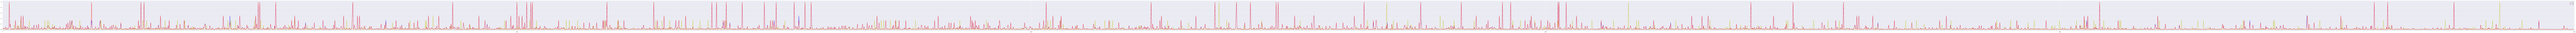

In [0]:
from matplotlib.pyplot import figure
fig = plt.figure(num=None, figsize=(500, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.subplots()
ax.plot(RR_fra_rating_5, 'y', label = 'Q1')
ax.plot(RR_Q2, 'b', label = 'Q2')
ax.plot(RR_Q4, 'r', label = 'Q4')
ax.legend()
plt.xlim([0,5000])
plt.show()


## Question 5

### LSA content-based recommender based on the aggregated user representation




In [8]:
#construct book feature matrix
#extract titles and authors from books_df
corpus = []
for title,author in books_df[["title","authors"]].values:
  corpus.append(title + " " +author)

#create one-hot encoding representation (text_rep)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary = True)
text_rep = vectorizer.fit_transform(corpus)

#deploy LSA to reduce dimensionalty  (dense_rep_cvt)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20,n_iter=7, random_state=42)
dense_rep = svd.fit_transform(text_rep)  
dense_rep_cvt = np.asarray(dense_rep)
print("size of book feature matrix :", dense_rep_cvt.shape)

size of book feature matrix : (7293, 20)


In [11]:
#constrcut utility matrix
new_df =  ratings_df[ratings_df['rating'] > 3]

util_matrix = [[0 for col in range(len(dense_rep))] for row in range(len(uid_map1))]

for i in range(0, len(uid_map1)):
    for book_id in new_df[new_df['user_id'] == i][["book_id"]].values:
      j = iid_map3[book_id[0]] 
      util_matrix[i][j] = 1  
print("size of utility matrix :", len(util_matrix), " x " ,len(util_matrix[0]))

size of utility matrix : 5000  x  7293


In [12]:
#compute  user feature matrix using book feature matrix and utility matrix
user_fea_matrix = [[0 for col in range(len(uid_map1))] for row in range(len(dense_rep[0]))]
for i in range(0, len(dense_rep[0])):
  for j in range(0, len(uid_map1)):
    user_fea_matrix[i][j] = sum(util_matrix[j] * dense_rep[:,i])
    
user_fea_matrix_cvt = np.asarray(user_fea_matrix)
print("size of user feature matrix :", user_fea_matrix_cvt.shape)

size of user feature matrix : (20, 5000)


In [13]:
#predict ratings using user feature matrix and book feature matrix
#compute the cosine similarity for all books to each user
for i in range(0, len(uid_map1)):
  for j in range(0, len(dense_rep)):
    if(util_matrix[i][j] == 0):
      util_matrix[i][j] = sum(user_fea_matrix_cvt[:,i] * dense_rep_cvt[j]) / (np.linalg.norm(user_fea_matrix_cvt[:,i]) * np.linalg.norm(dense_rep_cvt[j]))  

util_matrix_cvt = []
for i in range(0, len(uid_map1)):
  temp = np.asarray(util_matrix[i])
  util_matrix_cvt.append(temp)
  
#evaluate in terms of MRR
MRR_Q5_a = calc_reciprank(test_dataset, util_matrix_cvt, train=exp_dataset).mean()
print("MRR of Q5-a is : ", MRR_Q5_a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


MRR of Q5-a is :  0.014430493426955855


### LSA content-based recommender based on the weighting-rated cosine

In [15]:
#constrcut utility matrix, based on users' ratings (3, 4, 5)
new_df =  ratings_df[ratings_df['rating'] >= 3]

util_matrix = [[0 for col in range(len(dense_rep))] for row in range(len(uid_map1))]
user_rating_count = []

for i in range(0, len(uid_map1)):
    for book_id, rating in new_df[new_df['user_id'] == i][["book_id", "rating"]].values:
      j = iid_map3[book_id]
      util_matrix[i][j] = rating 
    user_rating_count.append(new_df[new_df['user_id'] == i]['rating'].count())
print("size of utility matrix :", len(util_matrix), " x " ,len(util_matrix[0]))

size of utility matrix : 5000  x  7293


In [17]:
#construct user feature matrix using utility matrix and book feature matrix
user_fea_matrix_b = [[0 for col in range(len(uid_map1))] for row in range(len(dense_rep[0]))]

for i in range(0, len(dense_rep[0])):
  for j in range(0, len(uid_map1)):
    user_fea_matrix_b[i][j] = sum(util_matrix[j] * dense_rep[:,i]) / user_rating_count[j]
    
user_fea_matrix_cvt_b = np.asarray(user_fea_matrix_b)
print("size of user feature matrix :", user_fea_matrix_cvt_b.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


size of user feature matrix : (20, 5000)


In [18]:
#compute weighted cosine similarity using book feature matrix and user feature matrix
for i in range(0, len(uid_map1)):
  for j in range(0, len(dense_rep)):
    if(util_matrix[i][j] == 0):
      util_matrix[i][j] = sum(user_fea_matrix_cvt_b[:,i] * dense_rep_cvt[j]) / (np.linalg.norm(user_fea_matrix_cvt_b[:,i]) * np.linalg.norm(dense_rep_cvt[j]))  

util_matrix_cvt_b = []
for i in range(0, len(uid_map1)):
  temp = np.asarray(util_matrix[i])
  util_matrix_cvt_b.append(temp)
  
#evaluate in terms of MRR
MRR_Q5_b = calc_reciprank(test_dataset, util_matrix_cvt_b, train=exp_dataset).mean()
print("MRR of Q5-b is : ", MRR_Q5_b)

MRR of Q5-b is :  0.021109124828186582


## Question 6

In [0]:
score_LSA_cb_2 = util_matrix_cvt_b

### Attemp 1 

In [0]:
#input features to be used:
#Fractino of 5* ratings: fra_rating_5                                         x1
#ImplicitFactorizationModel on explicit data (32): score_imodel_32_on_exp     x2 
#ImplicitFactorizationModel on implicit data(128): score_imodel_128_on_imp    x2
#LSA content-based recommender 2: score_LSA_cb_2                              x1

In [31]:
comb_sum_1 = []
for i in range(0, len(fra_rating_5)):
  temp = []
  for j in range(0, len(fra_rating_5[0])):
    temp.append(fra_rating_5[i][j] + score_imodel_32_on_exp[i][j]*2 + score_imodel_128_on_imp[i][j]*2 + score_LSA_cb_2[i][j])
  temp_2 =  np.asarray(temp)
  comb_sum_1.append(temp_2)
  
RR_1 = calc_reciprank(imp_validation, comb_sum_1, train=imp_train)
MRR_1 = RR_1.mean()
print("MRR of attempt 1 is : ", MRR_1)


MRR of attempt 1 is :  0.22785630428981643


### Attemp 2

In [0]:
#input features to be used:
#Fractino of 5* ratings: fra_rating_5                                         x2
#ImplicitFactorizationModel on explicit data (32): score_imodel_32_on_exp     x4 
#ImplicitFactorizationModel on implicit data(128): score_imodel_128_on_imp    x5
#LSA content-based recommender 2: score_LSA_cb_2                              x2

In [32]:
comb_sum_2 = []
for i in range(0, len(fra_rating_5)):
  temp = []
  for j in range(0, len(fra_rating_5[0])):
    temp.append(fra_rating_5[i][j]*2 + score_imodel_32_on_exp[i][j]*4 + score_imodel_128_on_imp[i][j]*5 + score_LSA_cb_2[i][j]*2)
  temp_2 =  np.asarray(temp)
  comb_sum_2.append(temp_2)
  
RR_2 = calc_reciprank(imp_validation, comb_sum_2, train=imp_train)
MRR_2 = RR_2.mean()
print("MRR of attempt 2 is : ", MRR_2)

MRR of attempt 2 is :  0.23837892749063194


### Attemp 3

In [0]:
#input features to be used:
#Fractino of 5* ratings: fra_rating_5                                         x1
#ImplicitFactorizationModel on explicit data (32): score_imodel_32_on_exp     x2 
#ImplicitFactorizationModel on implicit data(128): score_imodel_128_on_imp    x2
#LSA content-based recommender 2: score_LSA_cb_2                              x1
#ExplicitFactorizationModel : score_emodel                                    x1

In [33]:
comb_sum_3 = []
for i in range(0, len(fra_rating_5)):
  temp = []
  for j in range(0, len(fra_rating_5[0])):
    temp.append(fra_rating_5[i][j]*1 + score_imodel_32_on_exp[i][j]*2+ score_imodel_128_on_imp[i][j]*2 + score_LSA_cb_2[i][j]*2 + score_emodel[i][j]*1)
  temp_2 =  np.asarray(temp)
  comb_sum_3.append(temp_2)
  
RR_3 = calc_reciprank(imp_validation, comb_sum_3, train=imp_train)
MRR_3 = RR_3.mean()
print("MRR of attempt 3 is : ", MRR_3)

MRR of attempt 3 is :  0.22644324281218187



### the best model with test dataset

In [34]:
RR_final = calc_reciprank(test_dataset, comb_sum_2, train=imp_dataset)
MRR_final = RR_final.mean()
print(" Final MRR performance is : ", MRR_final)

 Final MRR performance is :  0.04442927440091621
